In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
savepgf = False

In [15]:
"""Implementation of lane extraction from semantic segmentation images."""

import os
import argparse

import yaml
import numpy as np
import cv2
from scipy.signal import find_peaks
from math import sin, cos
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches


def image_side_by_side(leftImg, leftTitle, rightImg, rightTitle, figsize=(20, 10), leftCmap=None, rightCmap=None):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    """
    _, axes = plt.subplots(ncols=2, figsize=figsize)
    if leftCmap == None:
        axes[0].imshow(leftImg)
    else:
        axes[0].imshow(leftImg, cmap=leftCmap)
    axes[0].set_title(leftTitle)

    if rightCmap == None:
        axes[1].imshow(rightImg)
    else:
        axes[1].imshow(rightImg, cmap=rightCmap)
    axes[1].set_title(rightTitle)


class LaneMarkingDetector(object):
    """
    Class for lane marking detection from semantic segmentation images.

    It performs inverse perspective mapping (IPM) to obtain the bird's eye view,
    then uses 2 approaches to detect lane marking pixels:
        - Sliding window: Used when there was no lane marking detected in previous images.
        - TODO: CTRV motion model: Used to predict the current positions of lane markings.
                                   It requires lane markings to be detected in previous images.
    """

    def __init__(self,
                 M,
                 px_per_meter_x,
                 px_per_meter_y,
                 warped_size,
                 valid_mask,
                 dist_fbumper_to_intersect,
                 lane_detect_params,
                 visualize=False):
        """ 
        Constructor method. 

        Input:
            M: Numpy.array of 3x3 matrix for IPM transform.
            px_per_meter_x: Pixels per meters in x in the Bird's eye view.
            px_per_meter_y: Pixels per meters in y in the Bird's eye view.
            warped_size: Image size tuple of IPM image (width, height).
            valid_mask: Numpy.array of booleans to mask out edge pixels caused by the border of the FOV.
            dist_fbumper_to_intersect: Meters from front bumper to the point where vertical FOV intersects the flat ground in x.
            lane_detect_params: Dict object storing lane detection algorithm parameters.
            visualize: Bool whether to visualize the lane detection process. Mainly used for debug.
                       If -O flag is used for the Python intepreter, this flag is ignored.
        """

        # IPM related data
        self.ipm_tform = M  # ipm stands for inverse perspective mapping
        self.warped_size = warped_size
        self.valid_mask = valid_mask
        self.px_per_meters_x = px_per_meter_x
        self.px_per_meters_y = px_per_meter_y
        self.dist_fbumper_to_intersect = dist_fbumper_to_intersect

        # Algorithm related parameters
        # Arrow Removal
        self._min_box_area = lane_detect_params['arrow_removal']['min_box_area']
        self._max_box_area = lane_detect_params['arrow_removal']['max_box_area']
        self._min_w2h_ratio = lane_detect_params['arrow_removal']['min_w2h_ratio']
        self._max_w2h_ratio = lane_detect_params['arrow_removal']['max_w2h_ratio']
        self._min_area = lane_detect_params['arrow_removal']['min_area']
        self._min_occup_ratio = lane_detect_params['arrow_removal']['min_occup_ratio']
        self._max_occup_ratio = lane_detect_params['arrow_removal']['max_occup_ratio']
        # Dilation
        self._dilation_iter = lane_detect_params['dilation']['n_iters']
        # Rotation
        self._yaw_rate_scale_h = lane_detect_params['rotation']['yaw_rate_scale_h']
        self._yaw_rate_scale_w = lane_detect_params['rotation']['yaw_rate_scale_w']
        self._hough_region_h = lane_detect_params['rotation']['hough_region_h']
        self._hough_region_w = lane_detect_params['rotation']['hough_region_w']
        self._hough_thres = lane_detect_params['rotation']['hough_thres']
        self._rot_thres = lane_detect_params['rotation']['rot_thres']
        # Histogram
        self._histo_region = lane_detect_params['histo']['histo_region']
        self._required_height = lane_detect_params['histo']['required_height']
        self._n_bins = lane_detect_params['histo']['n_bins']
        # Sliding window
        self._search_region = lane_detect_params['sliding_window']['search_region']
        self._n_windows = lane_detect_params['sliding_window']['n_windows']
        self._margin = lane_detect_params['sliding_window']['margin']
        self._recenter_minpix = lane_detect_params['sliding_window']['recenter_minpix']
        self._recenter_h_gap = lane_detect_params['sliding_window']['recenter_h_gap']
        self._recenter_v_gap = lane_detect_params['sliding_window']['recenter_v_gap']
        # Fitting
        self._sampling_ratio = lane_detect_params['fitting']['sampling_ratio']
        self.order = lane_detect_params['fitting']['order']

        # Lane marking data
        self.left_coeffs = None
        self.right_coeffs = None

        # Flag to visualize lane detection process
        self._visualize = visualize

    def update_lane_coeffs(self, lane_image, yaw_rate=0.):
        """
        Update lane marking coefficients of both sides.

        If lane markings were not detected before, it uses sliding window to detect lane markings.
        TODO: If lane markings were already detected, use Kalman filter to update or Kinematic detection.

        Input:
            lane_image: OpenCV image with supported data type (e.g. np.uint8). The image should have non-zero values only
                        at lane-related pixels, which is easy to obtained from a semantic image.
            yaw_rate: Yaw rate of the ego vehicle. (in rad/s)
        Output:
            left_coeffs: Polynomial coefficients of left marking.
            right_coeffs: Polynomial coefficients of right marking.
        """
        left_coords_fbumper, right_coords_fbumper = self.find_marking_points(
            lane_image, yaw_rate)

        if left_coords_fbumper.size != 0:
            self.left_coeffs = np.polyfit(
                left_coords_fbumper[0, :], left_coords_fbumper[1, :], self.order)
        else:
            self.left_coeffs = None

        if right_coords_fbumper.size != 0:
            self.right_coeffs = np.polyfit(
                right_coords_fbumper[0, :], right_coords_fbumper[1, :], self.order)
        else:
            self.right_coeffs = None

        # In debug mode, show figures plotted at each step finally
        # If this method is called in a loop in debug mode and the figures are not shown to block,
        # figures created at each loop will accumulate and drive the system to hang
        if __debug__:
            if self._visualize:
                plt.show()
        
        return self.left_coeffs, self.right_coeffs

    def find_marking_points(self, lane_image, yaw_rate):
        """
        Find marking points using the lane semantic image.

        Input:
            lane_image: OpenCV image with supported data type (e.g. np.uint8). The image should have non-zero values only
                        at lane-related pixels, which is easy to obtained from a semantic image.
            yaw_rate: Yaw rate of the ego vehicle. (in rad/s)
        Output:
            left_coords_fbumper: x-y coordinates of detected left lane marking points in fbumper frame (z-up)
            right_coords_fbumper: x-y coordinates of detected right lane marking points in fbumper frame (z-up)
        """
        # IPM to get bird's eye view
        bev_image = self._get_bev_image(lane_image)

        plt.imshow(bev_image)
        plt.axis('off')
        plt.show(block=False)

        ################ Save BEV image ################
        if savepgf:
            plt.savefig('images/bev_image.pgf', dpi=300)

        # Remove arrows from bev image that may interfere with lane detection
        self._remove_arrows(bev_image)

        edge_image = self._get_edge_image(bev_image)

        # Dilate edge image so markings are thicker and easier to detect.
        dilated_edge_image = cv2.dilate(
            edge_image, kernel=np.ones((3, 3), np.uint8), iterations=self._dilation_iter)

        if __debug__:
            if self._visualize:
                # image_side_by_side(edge_image, 'Edge Image',
                #                 dilated_edge_image, 'Dilated Edge Image')
                plt.imshow(edge_image)
                plt.axis('off')
                plt.show(block=False)

                ################ Save edge image ################
                if savepgf:
                    plt.savefig('images/edge_image.pgf', dpi=300)

                plt.imshow(dilated_edge_image)
                plt.axis('off')
                plt.show(block=False)

                ################ Save dilated edge image ################
                if savepgf:
                    plt.savefig('images/dilated_edge_image.pgf', dpi=300)

        # Sliding window approach
        # When the heading angle difference between ego vehicle and lane is too high, using histogram to find
        # starting search points is prone to fail. This method uses Hough transform to find major lines. If the
        # median angle of lines found is noticable, rotate the edge pixels around the center of image's bottom.
        # After rotation, lane markings should be more vertical and thus histogram is less likely to fail.
        # The resulting coordinates are aligned with ego frame (x forwards, y leftwards, origin at the center of image bottom)
        edge_coords_ego, rot_angle = self._try_rotate_edge_px(
            dilated_edge_image, yaw_rate)

        # Get histogram peaks and corresponding bases for sliding window search
        histo, bin_width = self._get_histo(edge_coords_ego)

        if __debug__:
            if self._visualize:
                # Plot histogram with edge pixels
                _, ax = plt.subplots(1, 1)
                # ax.plot(edge_coords_ego[1], edge_coords_ego[0], '.')
                ax.plot(histo, 'k')
                # ax.set_title('Histogram of (possibly) rotated edge pixels')
                ax.set_xlabel('Bin number []')
                ax.set_ylabel('Number of pixels []')
                ax.invert_xaxis()
                
                ################ Save histo image ################
                if savepgf:
                    plt.savefig('images/histo.pgf', dpi=300)

                plt.show(block=False)

        left_base_bin, right_base_bin = self._find_histo_peaks(histo)
        # Recover real base positions from bin numbers
        # Important: Coordinate system changes after _try_rotate_edge_px.
        # #          The large the bin number is, the more left on the y-axis it corresponds to.
        left_base = (left_base_bin-self._n_bins/2)*bin_width - \
            bin_width/2 if left_base_bin else None
        right_base = (right_base_bin-self._n_bins/2)*bin_width - \
            bin_width/2 if right_base_bin else None

        # Sliding window search
        left_idc, right_idc = self._sliding_window_search(
            edge_coords_ego, left_base, right_base)

        # Get lane marking coordinates
        left_coords = edge_coords_ego[:, left_idc]
        right_coords = edge_coords_ego[:, right_idc]

        # Down sampling to reduce number of points to process
        if self._sampling_ratio < 1.0:
            if left_coords.size != 0:
                left_coords = left_coords[:, 0::int(1/self._sampling_ratio)]
            if right_coords.size != 0:
                right_coords = right_coords[:, 0::int(1/self._sampling_ratio)]

        # Rotate coordinates back to the original orientation if pixels were rotated
        if rot_angle is not None:
            sin_minus_rot_angle = sin(0-rot_angle)  # 0 before minus sign to stop pylint from whining
            cos_minus_rot_angle = cos(0-rot_angle)
            rotm = np.array([[cos_minus_rot_angle, -sin_minus_rot_angle],
                             [sin_minus_rot_angle, cos_minus_rot_angle]])
            left_coords = rotm @ left_coords
            right_coords = rotm @ right_coords

        # Map from pixels to meters
        left_coords_fbumper = left_coords.astype(np.float)
        right_coords_fbumper = right_coords.astype(np.float)
        left_coords_fbumper[0, :] = left_coords_fbumper[0, :] / self.px_per_meters_x
        left_coords_fbumper[1, :] = left_coords_fbumper[1, :] / self.px_per_meters_y
        right_coords_fbumper[0, :] = right_coords_fbumper[0, :] / self.px_per_meters_x
        right_coords_fbumper[1, :] = right_coords_fbumper[1, :] / self.px_per_meters_y

        # Convert to coordinates wrt front bumper
        left_coords_fbumper[0, :] += self.dist_fbumper_to_intersect
        right_coords_fbumper[0, :] += self.dist_fbumper_to_intersect

        if __debug__:
            if self._visualize:
                # Plot detected marking points on dilated edge image
                left_pts_in_image = np.zeros(left_coords.shape)
                right_pts_in_image = np.zeros(right_coords.shape)
                left_pts_in_image[0] = self.warped_size[0]//2 - left_coords[1]
                left_pts_in_image[1] = self.warped_size[1] - left_coords[0]
                right_pts_in_image[0] = self.warped_size[0]//2 - right_coords[1]
                right_pts_in_image[1] = self.warped_size[1] - right_coords[0]

                _, ax = plt.subplots(ncols=2)
                ax[0].imshow(dilated_edge_image)
                ax[0].plot(left_pts_in_image[0], left_pts_in_image[1], '.', ms=0.5)
                ax[0].plot(right_pts_in_image[0],
                        right_pts_in_image[1], '.', ms=0.5)
                ax[0].set_title('Extracted Marking Pixels')

                ax[1].plot(left_coords_fbumper[1], left_coords_fbumper[0], '.', ms=0.5)
                ax[1].plot(right_coords_fbumper[1], right_coords_fbumper[0], '.', ms=0.5)
                ax[1].set_xlim(-self.warped_size[0]/2 / self.px_per_meters_y,
                            self.warped_size[0]/2 / self.px_per_meters_y)
                ax[1].set_ylim(-2, self.warped_size[1] / self.px_per_meters_x)
                ax[1].invert_xaxis()
                ax[1].set_title('Marking Points in Front Bumper Frame')
                ax[1].set_xlabel('y (m)')
                ax[1].set_ylabel('x (m)')
                plt.show(block=False)

        return left_coords_fbumper, right_coords_fbumper

    def _get_bev_image(self, image):
        """ 
        Perform IPM to get bird's eye view image

        Input:
            image: OpenCV image with supported data type (e.g. np.uint8).
        Output:
            Bird's eye view image
        """

        return cv2.warpPerspective(
            image, self.ipm_tform, self.warped_size)

    def _remove_arrows(self, bev_image):
        """
        Remove arrows on the road surface.

        Arrows' existence can be detrimental to lane marking detection. This method uses 
        structural analysis to find the features of arrows, based on which arrows are removed.
        This method modifies the input image directly.

        Input/Output:
            bev_image: OpenCV image in bird's eye view with supported data type (e.g. np.uint8). 
                        The image should have non-zero values only at lane-related pixels, 
                        which is easy to obtained from a semantic image. 
                        The image is modified in this method.
        """
        _, labels, stats, _ = cv2.connectedComponentsWithStats(bev_image)
        box_areas = stats[:, 2] * stats[:, 3]
        w2h_ratios = stats[:, 2] / stats[:, 3]
        occup_ratio = stats[:, 4] / box_areas
        selected = np.logical_and.reduce([box_areas > self._min_box_area,
                                          box_areas < self._max_box_area,
                                          w2h_ratios > self._min_w2h_ratio,
                                          w2h_ratios < self._max_w2h_ratio,
                                          stats[:, 4] > self._min_area,
                                          occup_ratio > self._min_occup_ratio,
                                          occup_ratio < self._max_occup_ratio])

        for idx in np.where(selected)[0]:
            bev_image[labels == idx] = 0

    def _get_edge_image(self, bev_image):
        """ 
        Get veritcal edge image in the bird's eye view.

        Input:
            bev_image: OpenCV image in bird's eye view with supported data type (e.g. np.uint8). 
                       The image should have non-zero values only at lane-related pixels, 
                       which is easy to obtained from a semantic image.
        Output:
            Edge image in the bird's eye view.
        """

        # Extract edges
        # Vertical Sobel filter is enough in our case, since we have crisp clear semantic image and only care about vertical edges
        edge_image = cv2.Sobel(bev_image, cv2.CV_64F, 1, 0, ksize=3)
        edge_image[edge_image != 0] = 1     # turn every non-zero pixels into 1

        # Remove edges caused by the border of the FOV using a predefined mask
        if self.valid_mask is not None:
            edge_image = edge_image.astype(np.uint8) & self.valid_mask

        return edge_image

    def _try_rotate_edge_px(self, edge_image, yaw_rate):
        """
        Try rotating edge pixels if the major lines in the lower half of edge image are tilted.

        This method uses Hough transform to find major lines. If the median angle of the lines found 
        is noticable, rotate the image around the center of image's  bottom to make markings more vertical.
        The returned edge coordinates are transformed to align with the ego vehicle's frame:
            - Origin at the center of the image bottom. X-axis points up. Y-axis points left.
        It is thus not in the computer vision's convention anymore.

        Input:
            edge_image: Edge image in the bird's eye view.
            yaw_rate: Yaw rate of the ego vehicle. (in rad/s)
        Output:
            edge_coords_ego: Coordinates of edge pixels aligned with the ego frame (x-up, y-left).
                             Coordinates are rotated if needed. 
                             The caller can tell if it is the case by the value of rot_angle.
            rot_angle: Rotation angle in rad. It is None if no rotation is needed.
        """
        # Image u-v coordinates of nonzero pixels (2-by-N)
        nonzero_u = edge_image.nonzero()[1]
        nonzero_v = edge_image.nonzero()[0]

        # Get coordinates of edge pixels aligned with ego vehicle's frame (x-up, y-left)
        edge_coords_ego = np.zeros((2, nonzero_u.shape[0]))
        edge_coords_ego[0] = self.warped_size[1] - \
            nonzero_v     # x (positive upwards)
        edge_coords_ego[1] = self.warped_size[0]//2 - \
            nonzero_u  # y (positive leftwards)

        # Set the considered region of image when performing Hough transform
        half_width = self.warped_size[0] // 2
        left_idx = int(half_width - half_width * self._hough_region_w)
        right_idx = int(half_width + half_width * self._hough_region_w)

        # If yaw rate is positive, increase the considered region on the left
        if yaw_rate > 0:
            left_idx -= int(self._yaw_rate_scale_w * yaw_rate)
            left_idx = max((0, left_idx))
        # Otherwise, increase the considered region on the right
        else:
            right_idx -= int(self._yaw_rate_scale_w * yaw_rate)
            right_idx = min((self.warped_size[0], right_idx))

        # Vertical region to be considered
        upper_idx = int(
            self.warped_size[1]*(1-self._hough_region_h) + abs(yaw_rate) * self._yaw_rate_scale_h)
        # considered at least 200 px in height
        upper_idx = min(self.warped_size[1] - 200, upper_idx)

        lines = cv2.HoughLinesP(
            edge_image[upper_idx:, left_idx:right_idx], 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=50)

        if __debug__:
            if self._visualize:
                # Plot hough lines on the cropped edge image
                edge_image_crop = edge_image[upper_idx:,
                                            left_idx:right_idx].copy() * 255

                if lines is not None:
                    for line in lines:
                        x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
                        cv2.line(edge_image_crop, (x1, y1),
                                (x2, y2), 100, 2)

                _, ax = plt.subplots(1, 1)
                ax.imshow(edge_image_crop)
                ax.set_title('Hough segments on cropped edge image')

        # TODO: When hough transform can't find lines in the lower half of image,
        # it's an indication that there is no good lines to detect
        if lines is not None:
            # HoughLinesP
            x1, y1, x2, y2 = lines[:, :, 0], lines[:,
                                                   :, 1], lines[:, :, 2], lines[:, :, 3]
            angles = np.arctan2((x2 - x1), (y2 - y1))
            angles[angles > np.pi/2] -= np.pi
            angles[angles < -np.pi/2] += np.pi

            rot_angle = -np.median(angles)
        else:
            rot_angle = None

        # Rotate edge pixels when angle magnitude larger than threshold
        if rot_angle and abs(rot_angle) > self._rot_thres * np.pi / 180:
            # Rotation matrix
            sin_rot_angle = sin(rot_angle)
            cos_rot_angle = cos(rot_angle)
            rotm = np.array([[cos_rot_angle, -sin_rot_angle],
                             [sin_rot_angle, cos_rot_angle]])

            edge_coords_ego = rotm @ edge_coords_ego
        else:
            rot_angle = None

        return edge_coords_ego, rot_angle

    def _get_histo(self, edge_coords):
        """ 
        Get histogram of edge pixels.

        The peaks in histogram is then used as starting points for sliding window search.
        The warped image size is used to determine parameters although the input is not the image.
        Since the input coordinates are obtained from the warped image, it is reasonable.

        Input:
            edge_coords: 2-by-N Numpy.array of edge pixel coordinates aligned with ego vehicle's frame (x-up, y-left)
        Output:
            histogram: Histogram of x values of input edge_coords
            bin_width: Bin width in pixels
        """
        # Get the upper limit of the image region
        upper = self._histo_region * self.warped_size[1]

        histogram, _ = np.histogram(edge_coords[1, edge_coords[0] < upper],
                                    bins=self._n_bins,
                                    range=(-self.warped_size[0]//2, self.warped_size[0]//2))
        bin_width = self.warped_size[0] / self._n_bins

        return histogram, bin_width

    def _find_histo_peaks(self, histogram):
        """ Find at most 2 peaks as lane marking searching bases from histogram. """
        # Find peaks above required height
        peaks, _ = find_peaks(histogram, height=self._required_height)
        # Find at most 2 peaks from the middle towards left and towards right
        # Return None if no peaks found
        half_idx = histogram.shape[0]/2

        # Note that the passed-in histogram is in reverse order (Larger bin number, more left)
        left_base_bin = peaks[peaks >= half_idx][0] if peaks[peaks >=
                                                              half_idx].size != 0 else None
        right_base_bin = peaks[peaks < half_idx][-1] if peaks[peaks <
                                                             half_idx].size != 0 else None
        return left_base_bin, right_base_bin

    def _sliding_window_search(self, edge_coords_ego, left_base, right_base):
        """ 
        Find lane marking edge pixels using sliding window. 

        Although it processes just the edge pixel coordinates, the size of the warped image is used to determine
        the window size. Since the edge coordinates are obtained from the warped image, this should be reasonable.

        Input:
            edge_coords_ego: Coordinates of edge pixels aligned with ego vehilce's frame (x-up, y-left)
            left_base: Starting point to search for left marking.
            right_base: Starting point to search for right marking.
        Output:
            left_idc: Indices of possible left marking points.
            right_idc: Indices of possible right marking points.
        """
        # Create empty lists to store left and right lane pixel indices
        left_idc = []
        right_idc = []

        if edge_coords_ego.size == 0:
            return left_idc, right_idc

        # x and y are aligned with the ego frame in this method!!!
        min_x = min(edge_coords_ego[0])

        # Set height of windows
        window_height = int(
            self.warped_size[1] * self._search_region / self._n_windows)

        # The shift to recenter the next window
        shift = 0

        if left_base:
            # Initial windows' positions
            left_win_h_curr = int(left_base)
            left_win_v_curr = min_x
            search_left = True
        else:
            search_left = False

        if right_base:
            right_win_h_curr = int(right_base)
            right_win_v_curr = min_x
            search_right = True
        else:
            search_right = False

        if __debug__:
            if self._visualize:
                # List to store tuples (x, y, width, height)
                boxs = []
                window_width = 2 * self._margin

        for win_count in range(self._n_windows):
            # Left markings
            if search_left:
                # Vertical
                win_v_left_low = left_win_v_curr + win_count * window_height
                win_v_left_high = left_win_v_curr + \
                    (win_count + 1) * window_height
                # Horizontal
                win_h_left_low = left_win_h_curr - self._margin
                win_h_left_high = left_win_h_curr + self._margin
                good_left_idc = ((edge_coords_ego[0] >= win_v_left_low) & (edge_coords_ego[0] < win_v_left_high) &
                                 (edge_coords_ego[1] >= win_h_left_low) & (edge_coords_ego[1] < win_h_left_high)).nonzero()[0]

                if __debug__:
                    if self._visualize:
                        # Store boxes for visualization
                        boxs.append((win_h_left_low, win_v_left_low,
                                    window_width, window_height))

                left_idc += list(good_left_idc)

                # Find the points with max and min y values for split/merge detection
                if good_left_idc.size != 0:
                    min_y_idx = np.argmin(edge_coords_ego[1, good_left_idc])
                    max_y_idx = np.argmax(edge_coords_ego[1, good_left_idc])
                    x1 = edge_coords_ego[0, good_left_idc][min_y_idx]
                    x2 = edge_coords_ego[0, good_left_idc][max_y_idx]
                    y1 = edge_coords_ego[1, good_left_idc][min_y_idx]
                    y2 = edge_coords_ego[1, good_left_idc][max_y_idx]
                    not_split = abs(
                        y1 - y2) < self._recenter_h_gap or abs(x1 - x2) > self._recenter_v_gap

                # Recenter next window if enough points found in current window and no split/merge detected
                if len(good_left_idc) > self._recenter_minpix and not_split:
                    newx = np.int(np.mean(edge_coords_ego[1, good_left_idc]))
                    if win_count > 0:
                        shift = newx - left_win_h_curr
                    left_win_h_curr = newx
                else:
                    left_win_h_curr += shift

            # Right markings
            if search_right:
                # Vertical
                win_v_right_low = right_win_v_curr + win_count * window_height
                win_v_right_high = right_win_v_curr + \
                    (win_count + 1) * window_height
                # Horizontal
                win_h_right_low = right_win_h_curr - self._margin
                win_h_right_high = right_win_h_curr + self._margin

                good_right_idc = ((edge_coords_ego[0] >= win_v_right_low) & (edge_coords_ego[0] < win_v_right_high) &
                                  (edge_coords_ego[1] >= win_h_right_low) & (edge_coords_ego[1] < win_h_right_high)).nonzero()[0]

                if __debug__:
                    if self._visualize:
                        # Store boxes for visualization
                        boxs.append((win_h_right_low, win_v_right_low,
                                    window_width, window_height))

                right_idc += list(good_right_idc)

                # Find the points with max and min y values for split/merge detection
                if good_right_idc.size != 0:
                    min_y_idx = np.argmin(edge_coords_ego[1, good_right_idc])
                    max_y_idx = np.argmax(edge_coords_ego[1, good_right_idc])
                    x1 = edge_coords_ego[0, good_right_idc][min_y_idx]
                    x2 = edge_coords_ego[0, good_right_idc][max_y_idx]
                    y1 = edge_coords_ego[1, good_right_idc][min_y_idx]
                    y2 = edge_coords_ego[1, good_right_idc][max_y_idx]
                    not_split = abs(
                        y1 - y2) < self._recenter_h_gap or abs(x1 - x2) > self._recenter_v_gap

                # Recenter next window if enough points found in current window and no split/merge detected
                if len(good_right_idc) > self._recenter_minpix and not_split:
                    newx = np.int(np.mean(edge_coords_ego[1, good_right_idc]))
                    if win_count > 0:
                        shift = newx - right_win_h_curr
                    right_win_h_curr = newx
                else:
                    right_win_h_curr += shift

        if __debug__:
            if self._visualize:
                # Plot extracted points on (possibly) rotated edge pixels
                _, ax = plt.subplots(1, 1)
                ax.plot(edge_coords_ego[1], edge_coords_ego[0], 'k.', ms=1, rasterized=True)

                ax.plot(edge_coords_ego[1, left_idc],
                        edge_coords_ego[0, left_idc], '.', ms=0.5, rasterized=True)
                ax.plot(edge_coords_ego[1, right_idc],
                        edge_coords_ego[0, right_idc], '.', ms=0.5, rasterized=True)

                for box in boxs:
                    ax.add_patch(patches.Rectangle(
                        box[0:2], box[2], box[3], fill=False))
                
                ax.invert_xaxis()
                # ax.set_title('Extracted points from (possibly) rotated pixels')
                ax.set_xlabel('$x$ [px]')
                ax.set_ylabel('$y$ [px]')
                plt.axis('equal')

                ################ Save sliding window image ################
                if savepgf:
                    plt.savefig('images/sw_search.pgf', dpi=300)

                plt.show(block=False)

        return left_idc, right_idc


In [16]:
def single(folder_name, image_idx):
    argparser = argparse.ArgumentParser(
        description='Lane Detection using Semantic Images')
    argparser.add_argument('vision_params', type=argparse.FileType(
        'r'), help='yaml file for vision algorithm parameters')
    args = argparser.parse_args(args=['../settings/vision.yaml'])

    # Read parameters from yaml file
    with args.vision_params as vision_params_file:
        vision_params = yaml.safe_load(vision_params_file)

    # Load parameters for bird's eye view projection
    with open('../ipm_data.pkl', 'rb') as f:
        ipm_data = pickle.load(f)
    M = ipm_data['M']
    warped_size = ipm_data['bev_size']
    valid_mask = ipm_data['valid_mask']
    px_per_meter_x = ipm_data['px_per_meter_x']
    px_per_meter_y = ipm_data['px_per_meter_y']
    dist_fbumper_to_intersect = ipm_data['dist_fbumper_to_intersect']

    # Load data
    mydir = os.path.join('../recordings', folder_name)
    with open(os.path.join(mydir, 'sensor_data.pkl'), 'rb') as f:
        sensor_data = pickle.load(f)

    ss_images = sensor_data['semantic_camera']['ss_image']
    yaw_rates = sensor_data['imu']['gyro_z']

    # Extract lane-relevant semantic labels (road line and sidewalk)
    ss_image = ss_images[image_idx]
    lane_image = (ss_image == 6) | (ss_image == 8).astype(np.uint8)

    plt.imshow(lane_image)
    plt.axis('off')
    plt.show(block=False)

    ################ Save lane image ################
    if savepgf:
        plt.savefig('images/lane_image.pgf', dpi=300)

    lane_detector = LaneMarkingDetector(M, px_per_meter_x, px_per_meter_y,
                                        warped_size, valid_mask,
                                        dist_fbumper_to_intersect,
                                        vision_params['lane'],
                                        visualize=True)

    lane_detector.update_lane_coeffs(lane_image, yaw_rates[image_idx])

    # Verify lane marking results
    ipm_fig, ipm_ax = plt.subplots(1, 1)
    fb_fig, fb_ax = plt.subplots(1, 1)
    im = ipm_ax.imshow(
        255*np.ones((warped_size[1], warped_size[0])).astype(np.uint8), vmin=0, vmax=1.0)
    left_lane = ipm_ax.plot([], [])[0]
    right_lane = ipm_ax.plot([], [])[0]
    left_lane_fbumper = fb_ax.plot([], [])[0]
    right_lane_fbumper = fb_ax.plot([], [])[0]

    edge_image = lane_detector._get_bev_image(lane_image)
    im.set_data(edge_image)

    x = np.linspace(0, 12, 20)
    if lane_detector.left_coeffs is not None:
        coeffs = lane_detector.left_coeffs
        y = np.zeros(x.shape)
        for idx, coeff in enumerate(reversed(coeffs)):
            y += coeff * x**idx

        # x-y are wrt front bumper
        # Must convert back to BEV's coordinate
        v_img = edge_image.shape[0] - \
            (x - dist_fbumper_to_intersect) * lane_detector.px_per_meters_x
        u_img = edge_image.shape[1]//2 - y * lane_detector.px_per_meters_y

        left_lane.set_data(u_img, v_img)
        left_lane_fbumper.set_data(y, x)

    if lane_detector.right_coeffs is not None:
        coeffs = lane_detector.right_coeffs
        y = np.zeros(x.shape)
        for idx, coeff in enumerate(reversed(coeffs)):
            y += coeff * x**idx

        # x-y are wrt front bumper
        # Must convert back to BEV's coordinate
        v_img = edge_image.shape[0] - \
            (x - dist_fbumper_to_intersect) * lane_detector.px_per_meters_x
        u_img = edge_image.shape[1]//2 - y * lane_detector.px_per_meters_y

        right_lane.set_data(u_img, v_img)
        right_lane_fbumper.set_data(y, x)

    # ipm_ax.set_title(image_idx)
    # fb_ax.set_title('In Front Bumper Frame')
    ipm_ax.axis('off')

    fb_ax.set_aspect('equal')
    fb_ax.invert_xaxis()
    fb_ax.set_xlim((6, -6))
    fb_ax.set_ylim((0, 15))
    fb_ax.grid('on')
    fb_ax.set_xlabel(r'$y_\text{fb}$ [m]')
    fb_ax.set_ylabel(r'$x_\text{fb}$ [m]')

    ################ Save fitting results ################
    if savepgf:
        ipm_fig.savefig('images/lb_fit.pgf', dpi=300)
        fb_fig.savefig('images/lb_in_fb.pgf', dpi=300)
    plt.show()
    print(yaw_rates[image_idx])

In [17]:
if savepgf:
    import matplotlib
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
        'pgf.preamble': [r'\usepackage{siunitx} \usepackage{amsmath}']
    })
else:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    params = {'text.latex.preamble' : [r'\usepackage{siunitx} \usepackage{amsmath}']}
    plt.rcParams.update(params)

/home/lian999111/miniconda3/envs/carla/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


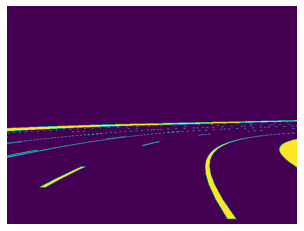

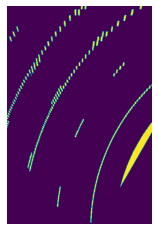

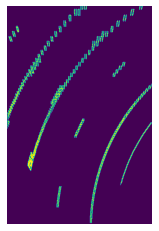

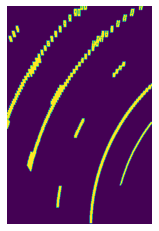

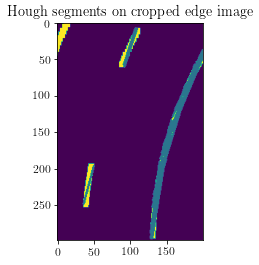

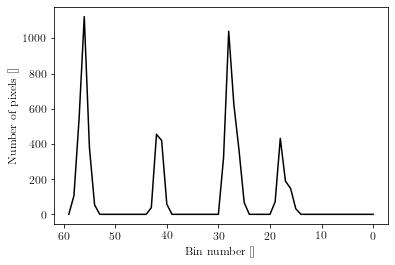

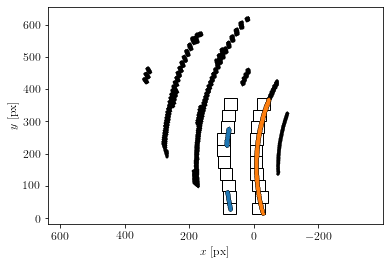

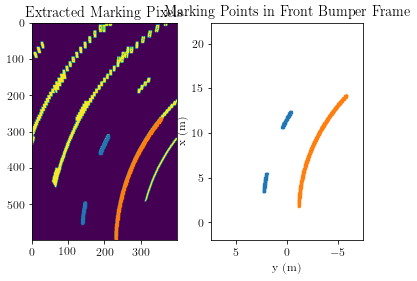

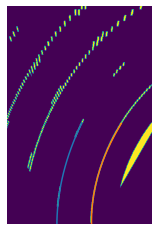

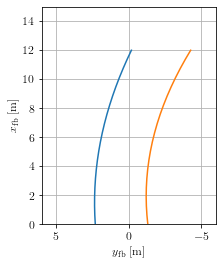

-0.007780133746564388


In [18]:
single('urban', 170)